In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

In [80]:
df = pd.read_csv('sales.csv')
df.head()

,Sales,Expenses,Profit,Transactions
0,524.835708,241.980663,43.248217,103
1,493.086785,227.739011,48.554813,141
2,532.384427,201.788911,42.075801,143
3,576.151493,180.591897,46.920385,122
4,488.292331,220.946699,31.063853,144


In [62]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [63]:
df.head()

,Sales,Expenses,Profit,Transactions
0,524.835708,241.980663,43.248217,103
1,493.086785,227.739010,48.554813,141
2,532.384427,201.788911,42.075801,143
3,576.151493,180.591897,46.920385,122
4,488.292331,220.946699,31.063853,144


# Z-Score Method

### Method - 1

In [24]:
# Calculate Z-scores for each column
z_scores = df.apply(zscore)

# Mark rows as outliers if any column has |z| > 3
outliers_z = (np.abs(z_scores) > 3).any(axis=1)

# Extract outliers
z_outliers_df = df[outliers_z]
#print("Z-Score Outliers:")
z_outliers_df

,Sales,Expenses,Profit,Transactions
1000,1500.0,800.0,200.0,500
1001,-200.0,-100.0,-50.0,-20
1002,2000.0,900.0,300.0,600
1003,-300.0,-150.0,-100.0,-30


### Method - 2

In [28]:
df['sales_z'] = (df['Sales']-df['Sales'].mean())/df['Sales'].std(ddof=0)

In [37]:
df[(df['sales_z']>3) | (df['sales_z']<-3)]

,Sales,Expenses,Profit,Transactions,sales_z
1000,1500.0,800.0,200.0,500,12.152394
1001,-200.0,-100.0,-50.0,-20,-8.547222
1002,2000.0,900.0,300.0,600,18.240516
1003,-300.0,-150.0,-100.0,-30,-9.764846


In [43]:
df.drop(columns=['sales_z'],inplace=True)

# IQR Method

In [44]:
# Compute IQR for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Mark rows as outliers
outliers_iqr = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)

# Extract outliers
iqr_outliers_df = df[outliers_iqr]

In [47]:
iqr_outliers_df

,Sales,Expenses,Profit,Transactions
24,472.780864,251.826295,19.804878,130
35,438.957818,247.219603,77.596600,62
61,490.717051,114.543721,48.626282,75
74,369.012745,229.888005,43.823481,127
101,478.967734,113.112339,40.979484,119
179,636.008458,166.892320,50.067998,71
209,692.636575,252.487302,49.992914,143
262,337.936633,216.162680,62.357822,92
305,505.866369,173.045961,81.099186,51
478,653.944040,173.375235,36.613942,133


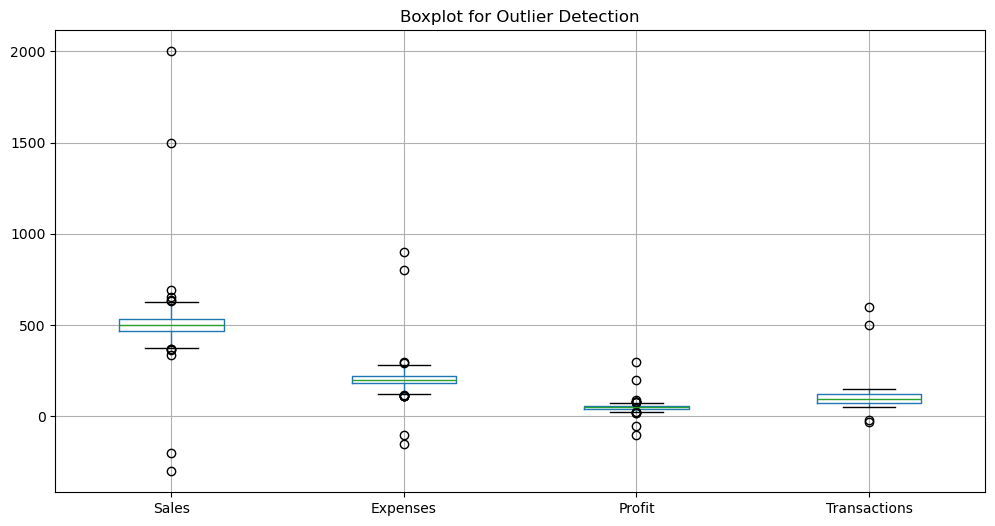

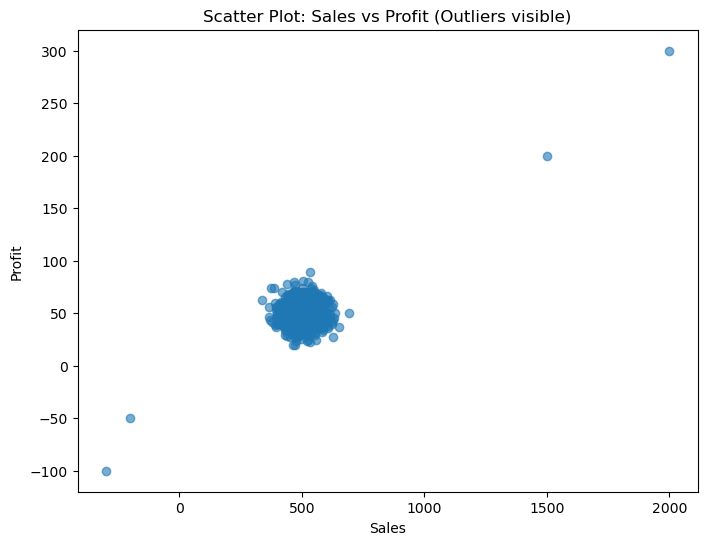

In [48]:
import matplotlib.pyplot as plt

# Boxplot for all columns
plt.figure(figsize=(12,6))
df.boxplot()
plt.title("Boxplot for Outlier Detection")
plt.show()

# Scatter plot example (Sales vs Profit)
plt.figure(figsize=(8,6))
plt.scatter(df['Sales'], df['Profit'], alpha=0.6)
plt.title("Scatter Plot: Sales vs Profit (Outliers visible)")
plt.xlabel("Sales")
plt.ylabel("Profit")
plt.show()

# Machine Learning (Isolation Forest, LOF, DBSCAN)

In [75]:
# --- 1. Isolation Forest ---
iso = IsolationForest(contamination=0.01, random_state=42)
df['iso_outlier'] = iso.fit_predict(df[['Sales','Expenses','Profit','Transactions']])

# --- 2. Local Outlier Factor (LOF) ---
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
df['lof_outlier'] = lof.fit_predict(df[['Sales','Expenses','Profit','Transactions']])

# --- 3. DBSCAN ---
dbscan = DBSCAN(eps=50, min_samples=5)
df['dbscan_outlier'] = dbscan.fit_predict(df[['Sales','Expenses','Profit','Transactions']])

# Count outliers detected by each method
outlier_counts = {
    "Isolation Forest": (df['iso_outlier'] == -1).sum(),
    "LOF": (df['lof_outlier'] == -1).sum(),
    "DBSCAN": (df['dbscan_outlier'] == -1).sum()
}

outlier_counts


{'Isolation Forest': np.int64(11), 'LOF': np.int64(11), 'DBSCAN': np.int64(5)}

### Hyperparameter Tuning (Try multiple contamination values

In [76]:
from sklearn.model_selection import ParameterGrid

contamination_values = [0.01, 0.02, 0.05]
best_model = None

for c in contamination_values:
    iso = IsolationForest(contamination=c, random_state=42)
    preds = iso.fit_predict(df[['Sales','Expenses','Profit','Transactions']])
    
    # Example metric: proportion of outliers flagged
    outlier_count = (preds == -1).sum()
    print(f"Contamination={c}, Outliers Detected={outlier_count}")
    
    # In practice, you’d use a proper metric (precision, recall, AUC)


Contamination=0.01, Outliers Detected=11
Contamination=0.02, Outliers Detected=21
Contamination=0.05, Outliers Detected=51


# Outlier Treatment 

In [81]:
df = pd.read_csv('sales.csv')

In [82]:
df.shape

(1004, 4)

In [83]:
iso = IsolationForest(contamination=0.01, random_state=42)
df['iso_outlier'] = iso.fit_predict(df[['Sales','Expenses','Profit','Transactions']])

In [85]:
(df['iso_outlier'] == -1).sum()

np.int64(11)

In [86]:
df[df['iso_outlier']==-1]

,Sales,Expenses,Profit,Transactions,iso_outlier
35,438.957817,247.219603,77.596600,62,-1
113,623.162106,214.870457,39.978125,53,-1
209,692.636575,252.487302,49.992914,143,-1
471,384.903942,181.706513,73.638725,106,-1
478,653.944040,173.375235,36.613942,133,-1
544,376.417775,181.933638,74.267165,148,-1
880,626.346621,228.945549,27.617688,78,-1
1000,1500.000000,800.000000,200.000000,500,-1
1001,-200.000000,-100.000000,-50.000000,-20,-1
1002,2000.000000,900.000000,300.000000,600,-1


## Remove Outliers (IQR method)

In [89]:
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_removed = df[(df['Sales'] >= lower_limit) & (df['Sales'] <= upper_limit)]
print("After removing:", df_removed.shape)

After removing: (992, 5)


In [90]:
df_removed[df_removed['iso_outlier']==-1]

,Sales,Expenses,Profit,Transactions,iso_outlier
35,438.957817,247.219603,77.596600,62,-1
113,623.162106,214.870457,39.978125,53,-1
471,384.903942,181.706513,73.638725,106,-1
544,376.417775,181.933638,74.267165,148,-1
880,626.346621,228.945549,27.617688,78,-1


## Cap/Floor (Winsorization)

In [91]:
q01, q99 = df['Sales'].quantile([0.01, 0.99])
df['Sales_capped'] = np.clip(df['Sales'], q01, q99)

In [94]:
df[df['iso_outlier']==-1]

,Sales,Expenses,Profit,Transactions,iso_outlier,Sales_capped
35,438.957817,247.219603,77.596600,62,-1,438.957817
113,623.162106,214.870457,39.978125,53,-1,622.750685
209,692.636575,252.487302,49.992914,143,-1,622.750685
471,384.903942,181.706513,73.638725,106,-1,390.172068
478,653.944040,173.375235,36.613942,133,-1,622.750685
544,376.417775,181.933638,74.267165,148,-1,390.172068
880,626.346621,228.945549,27.617688,78,-1,622.750685
1000,1500.000000,800.000000,200.000000,500,-1,622.750685
1001,-200.000000,-100.000000,-50.000000,-20,-1,390.172068
1002,2000.000000,900.000000,300.000000,600,-1,622.750685


## Transformation (Log Transform)

In [95]:
df['Sales_log'] = np.log1p(df['Sales'] - df['Sales'].min() + 1)  

In [97]:
df[df['iso_outlier']==-1]

,Sales,Expenses,Profit,Transactions,iso_outlier,Sales_capped,Sales_log
35,438.957817,247.219603,77.596600,62,-1,438.957817,6.607944
113,623.162106,214.870457,39.978125,53,-1,622.750685,6.829969
209,692.636575,252.487302,49.992914,143,-1,622.750685,6.902377
471,384.903942,181.706513,73.638725,106,-1,390.172068,6.532194
478,653.944040,173.375235,36.613942,133,-1,622.750685,6.862699
544,376.417775,181.933638,74.267165,148,-1,390.172068,6.519763
880,626.346621,228.945549,27.617688,78,-1,622.750685,6.833405
1000,1500.000000,800.000000,200.000000,500,-1,622.750685,7.496652
1001,-200.000000,-100.000000,-50.000000,-20,-1,390.172068,4.624973
1002,2000.000000,900.000000,300.000000,600,-1,622.750685,7.741534


## Binning

In [98]:
df['Sales_bin'] = pd.qcut(df['Sales'], q=4, labels=['Low','Med-Low','Med-High','High'])

In [100]:
df[df['iso_outlier']==-1]

,Sales,Expenses,Profit,Transactions,iso_outlier,Sales_capped,Sales_log,Sales_bin
35,438.957817,247.219603,77.596600,62,-1,438.957817,6.607944,Low
113,623.162106,214.870457,39.978125,53,-1,622.750685,6.829969,High
209,692.636575,252.487302,49.992914,143,-1,622.750685,6.902377,High
471,384.903942,181.706513,73.638725,106,-1,390.172068,6.532194,Low
478,653.944040,173.375235,36.613942,133,-1,622.750685,6.862699,High
544,376.417775,181.933638,74.267165,148,-1,390.172068,6.519763,Low
880,626.346621,228.945549,27.617688,78,-1,622.750685,6.833405,High
1000,1500.000000,800.000000,200.000000,500,-1,622.750685,7.496652,High
1001,-200.000000,-100.000000,-50.000000,-20,-1,390.172068,4.624973,Low
1002,2000.000000,900.000000,300.000000,600,-1,622.750685,7.741534,High


## Imputation

In [101]:
median_val = df['Sales'].median()
df['Sales_imputed'] = df['Sales'].apply(lambda x: median_val if (x < lower_limit or x > upper_limit) else x)

In [102]:
df[df['iso_outlier']==-1]

,Sales,Expenses,Profit,Transactions,iso_outlier,Sales_capped,Sales_log,Sales_bin,Sales_imputed
35,438.957817,247.219603,77.596600,62,-1,438.957817,6.607944,Low,438.957817
113,623.162106,214.870457,39.978125,53,-1,622.750685,6.829969,High,623.162106
209,692.636575,252.487302,49.992914,143,-1,622.750685,6.902377,High,501.265031
471,384.903942,181.706513,73.638725,106,-1,390.172068,6.532194,Low,384.903942
478,653.944040,173.375235,36.613942,133,-1,622.750685,6.862699,High,501.265031
544,376.417775,181.933638,74.267165,148,-1,390.172068,6.519763,Low,376.417775
880,626.346621,228.945549,27.617688,78,-1,622.750685,6.833405,High,626.346621
1000,1500.000000,800.000000,200.000000,500,-1,622.750685,7.496652,High,501.265031
1001,-200.000000,-100.000000,-50.000000,-20,-1,390.172068,4.624973,Low,501.265031
1002,2000.000000,900.000000,300.000000,600,-1,622.750685,7.741534,High,501.265031


## Robust Models

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

X = df.index.values.reshape(-1,1)
y = df['Sales']

lr = LinearRegression().fit(X, y)
rf = RandomForestRegressor().fit(X, y)

print("Linear Regression sensitive to outliers, Random Forest is more robust.")

Linear Regression sensitive to outliers, Random Forest is more robust.


## Keep Outliers (When They Are Signals)

In [105]:
# Example: Fraud detection → don't remove them
outliers = df[(df['Sales'] < lower_limit) | (df['Sales'] > upper_limit)]
outliers.head()

,Sales,Expenses,Profit,Transactions,iso_outlier,Sales_capped,Sales_log,Sales_bin,Sales_imputed
74,369.012745,229.888005,43.823481,127,1,390.172068,6.508788,Low,501.265031
179,636.008458,166.892321,50.067998,71,1,622.750685,6.843759,High,501.265031
209,692.636575,252.487302,49.992914,143,-1,622.750685,6.902377,High,501.265031
262,337.936633,216.162680,62.357822,92,1,390.172068,6.461369,Low,501.265031
478,653.944040,173.375235,36.613942,133,-1,622.750685,6.862699,High,501.265031


# 📊 Outlier Handling Methods — Comparison

| **Method**            | **How it Works** | **When to Use** | **Best Fit** |
|------------------------|------------------|-----------------|--------------|
| **Remove**             | Drop rows with extreme values | Outliers caused by errors/typos and dataset is large enough | Data cleaning |
| **Cap/Floor (Winsorize)** | Replace values beyond thresholds with nearest acceptable limit | Outliers are valid but too extreme, and you don’t want to lose data | Finance, sales data |
| **Transformation (Log, √, Box-Cox)** | Compress extreme values by scaling | When distribution is skewed due to large outliers | Regression models |
| **Binning**            | Group values into categories | When extreme values don’t matter individually | Risk scoring, credit rating |
| **Imputation**         | Replace with mean/median/mode | Outliers due to missing/error values | Healthcare, survey data |
| **Robust Models**      | Use ML models less sensitive to outliers (Random Forest, XGBoost) | When keeping outliers but still want good predictions | ML/AI tasks |
| **Keep Outliers**      | Leave them untouched | When outliers = signals (fraud, churn, disease) | Fraud detection, anomaly detection |

---

### 🟢 Interview Takeaway
> “The best method depends on context. If outliers are errors, remove or impute them.  
> If they’re valid but extreme, cap or transform them.  
> If they’re rare but important signals (fraud, disease), I keep them.  
> For ML, I prefer robust models like Random Forest or XGBoost.”
